# Quantum Simulation of the Schrödinger Equation

In this notebook, I will go over teh details of how to simulate the Schrödinger equation using a quantum computer/quantum algorithms. The Schrödinger equation is a fundamental equation in quantum mechanics that describes how the quantum state of a physical system changes over time. It is given by the following equation:

\begin{equation}
i\hbar\frac{\partial}{\partial t}|\psi(t)\rangle = \hat{H}|\psi(t)\rangle
\end{equation}

where $\hbar$ is the reduced Planck constant, $\hat{H}$ is the Hamiltonian operator, and $|\psi(t)\rangle$ is the quantum state of the system at time $t$. This notebook is a step by step process where I'll go over each of the needed steps to simulate the Schrödinger equation. The work in this notebook uses the Qiskit library for quantum computing. and is based on the work from the paper "Quantum simulation of the single-particle Schrödinger
equation" by Giuliano Benenti and Giuliano Striti Which can be found [here](https://pubs.aip.org/aapt/ajp/article/76/7/657/1038339/Quantum-simulation-of-the-single-particle).

In [1]:
# we import the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import scipy
from qiskit.circuit.library import QFT, HamiltonianGate
from qiskit.circuit.library import PhaseGate
from qiskit.circuit import parameter
from scipy.linalg import expm
from qiskit.algorithms import SciPyRealEvolver, TimeEvolutionProblem,TrotterQRTE
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from tqdm import tqdm
from matplotlib import rcParams

# Set the font family to Helvetica
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

# Use LaTeX for rendering text
rcParams['text.usetex'] = True

/var/folders/tm/f3mj_8392ynf5d34j_d9js4m0000gn/T/ipykernel_29200/1536291614.py:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import SciPyRealEvolver, TimeEvolutionProblem,TrotterQRTE


We begin by writing the discretizing the Schrödinger equation in the position basis. We can write the wavefunction as a linear combination of position basis states:

\begin{equation}
|\psi(t)\rangle = \sum_{j=0}^{N-1} c_j(t)|x_j\rangle
\end{equation}

where $|x_j\rangle$ is the position basis state at position $x_j$, and $c_j(t)$ is the probability amplitude of the particle being at position $x_j$ at time $t$. We can use the qubits as the discretized grid. We begin by discretizing the position space into $2^N$ points. We also have to initialize the particle using a wavefunction. We can use the following wavefunction:

\begin{equation}
\psi(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-x_0)^2}{2\sigma^2}} e^{ip_0(x - x_0)}
\end{equation}

where $x_0$ is the initial position of the particle, and $\sigma$ is the width of the wavefunction. We can use the following code to initialize the wavefunction:

```python

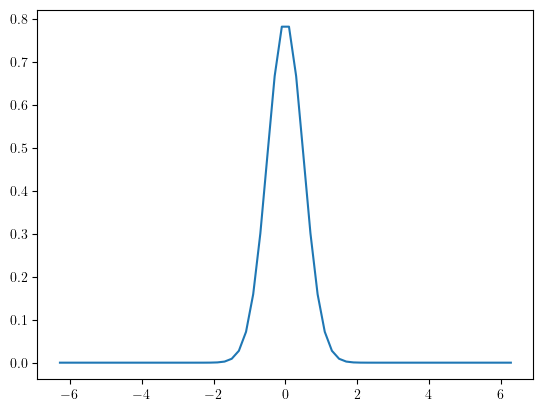

In [3]:
def make_discretized_positions(xmin, xmax, N):
    """
    Make a discretized position space

    """
    x = np.linspace(xmin, xmax, N)
    return x


def return_gaussian_wavefunction(x, mu, sigma, p0):
    """
    Make a gaussian wavefunction

    """
    wave = (1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-((x-mu)**2)/(2*sigma**2) + 1.0j* p0 * (x - mu)) 
    return wave


num_qubits = 6

# Define the position space

N = 2**num_qubits

x = make_discretized_positions(-2*np.pi, 2*np.pi, N)

# Define the wavefunction

mu = 0
sigma = 0.5
p0 = 0.0

wave = return_gaussian_wavefunction(x, mu, sigma, p0)

# Plot the wavefunction

plt.plot(x, np.real(wave))

We can see the the gaussian distribution nicely. Now, we need to initialize it into our quantum circuit

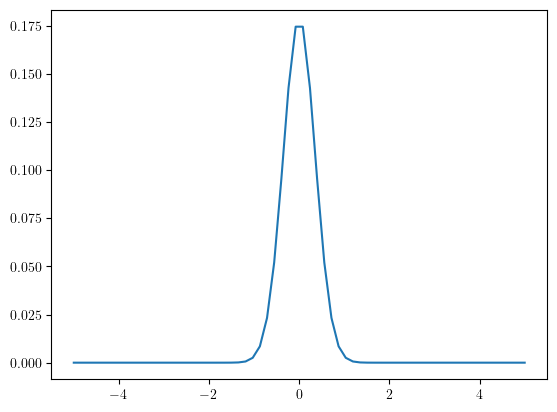

In [7]:
num_qubits = 6
# Define the position space

N = 2**num_qubits
d = 5
x = make_discretized_positions(-d, d, N)
p0 = 0.0
mu = -0
sigma = 0.5

psi = return_gaussian_wavefunction(x, mu, sigma, p0)

#normalize

psi /= np.linalg.norm(psi)

# initialie the quantum state

qc = QuantumCircuit(num_qubits + 1)

# initialize the quantum state

qc.initialize(psi, range(num_qubits))

#simulate to see if we return the same wavefunction

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend).result()
psi_qiskit = result.get_statevector()

# Plot the wavefunction

plt.plot(x, np.abs(psi)**2, label='Quantum Circuit')


Now, The Hamiltonian is defined as:

\begin{equation}
H = -\frac{1}{2} \frac{d^2}{dx^2} + V(x)
\end{equation}

Where, in our case we want to simulate:
\begin{equation}
\ket{\psi(x,t)} = H \ket{\psi(x,t_0)}
\end{equation}
The Hamiltonian operator has the form:
\begin{equation}
H = \exp(-iHt) = \exp(-iKt - iV(x)t)
\end{equation}
Sometimes, K and V do not commute, Thus, we have to use Trotterization. 
Where, we can represent the kinetic part as:
\begin{equation}
K = F^\dagger P F
\end{equation}
Where, $F$ is the Fourier transform operator, and $P$ is the momentum operator. Furthermore, we know that the x is discretized as:

\begin{equation}
x_k = -d + (k + 1/2)\delta x
\end{equation}
Where, $k$ is $\sum_j k_j2^j$ representing the binary representation of the number $k$. we can also rewrite x as:
\begin{equation}
x = \delta x \sum_j (k_j2^j + \beta)
\end{equation}
where, we define $\beta = -d + 1/2 / n$. We can replace into our equation for a linear potential and we get:
\begin{equation}
\exp(iV(x)t) = \exp(i(\delta x \sum_j (k_j2^j + \beta))t)
\end{equation}


The way that the grid is discretized is as follows:

\begin{equation}
\hat{k} = -\sqrt{\frac{1}{2^{n - 3}} \frac{\phi}{\Delta t}} \left(1 + \sum_{j=1}^n 2^{n-j}Z_j\right)
\end{equation}

where $Z_j$ is the Pauli-Z gate, $\phi$ is the number of time steps, and $\Delta t$ is the time step. For the quadratic term, we would have:

\begin{equation}
\exp(-i\hat{K}\Delta t) = \exp\left(-i\frac{\Delta t}{2} \hat{k}^2\right)
\end{equation}

Where $k^2$ is given by:

\begin{align}
\hat{k}^2 &= \frac{1}{2^{n - 3}} \frac{\phi}{\Delta t} \left(1 + \sum_{j=1}^n 2^{n-j}Z_j\right)^2
\\
&= \frac{1}{2^{n - 3}} \frac{\phi}{\Delta t} \left(1 + 2\sum_{j=1}^n 2^{n-j}Z_j + \sum_{j,k = 1}^{n} 2^{2n-j-k}Z_j Z_k\right)
\end{align}

We can also write the potential term as:

\begin{equation}
\exp(-iV(x)\Delta t) = \exp\left(-i\frac{\Delta t}{2} V(x)\right)
\end{equation}

However, we know that the global phase can be ignored

In [8]:
def make_linear_phase(qc,phi0,dt):
    
    num_qubits = qc.num_qubits - 1
    for i in range(num_qubits):
        phi = -np.sqrt(1 / 2**(num_qubits - 3) * phi0 / dt) * 2**(num_qubits - i)
        qc.p(phi, num_qubits - i - 1)

    return qc

/Users/lucasinigogamiz/anaconda3/envs/quantum_env/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


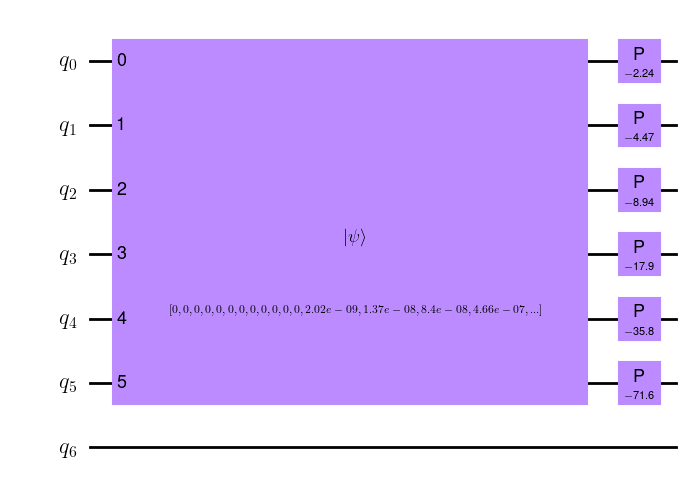

In [12]:
num_qubits = 6
qc = QuantumCircuit(num_qubits + 1) 

# initialize the quantum state

qc.initialize(psi, range(num_qubits))

# make the linear phase

dt = 0.1
phi0 = 1
qc = make_linear_phase(qc,phi0,dt)

# We can visualize the circuit

qc.draw('mpl')

In [13]:
# Ok, now let us do the quadratic phase

def make_quadratic_phase(qc, phi0, dt):
    num_qubits = qc.num_qubits - 1  # Assuming the last qubit is an auxiliary qubit
    auxiliary_qubit = num_qubits  # Index of the auxiliary qubit

    for i in range(num_qubits):
        phi = 1 / 2**(num_qubits - 3) * phi0 / dt * 2**(num_qubits - i)
        qc.p(phi, num_qubits - i - 1)


    # Your existing logic here, corrected for proper indexing
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            phi = 1 / 2**(num_qubits - 3) * phi0 / dt * 2**(2 * num_qubits - i - j)

            # Use auxiliary_qubit as the target for CX gates
            qc.cx(num_qubits - 1 - j, auxiliary_qubit)
            qc.cx(num_qubits - 1 - i, auxiliary_qubit)
            qc.p(phi, auxiliary_qubit)
            qc.cx(num_qubits - 1 - i, auxiliary_qubit)
            qc.cx(num_qubits - 1 - j, auxiliary_qubit)

    return qc

/Users/lucasinigogamiz/anaconda3/envs/quantum_env/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


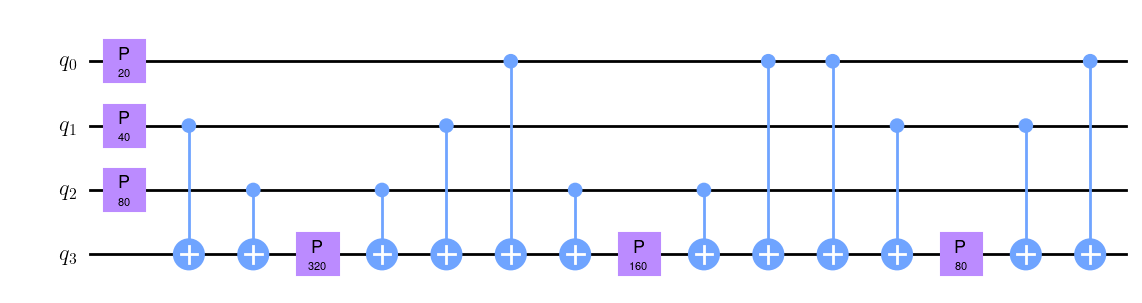

In [14]:

num_qubits = 3

qc = QuantumCircuit(num_qubits + 1)


qc = make_quadratic_phase(qc, phi0, dt)

qc.draw('mpl')



This is as expected and wanted. Now, we can use the following code to implement the kinetic and potential terms:

In [15]:
def make_hamiltonian(qc,phi0,dt,potential_type = 'linear'):

    num_qubits = qc.num_qubits - 1

    qc.append(QFT(num_qubits, inverse = True), range(num_qubits))
    qc.x(num_qubits-1)

    qc.barrier()
    qc = make_quadratic_phase(qc,phi0,dt)

    qc.barrier()

    qc.x(num_qubits-1)
    qc.append(QFT(num_qubits), range(num_qubits))

    qc.barrier()

    if potential_type == 'linear':
        qc = make_linear_phase(qc,phi0,dt)

    if potential_type == 'quadratic':
        qc = make_quadratic_phase(qc,phi0,dt)

    if potential_type == 'free':
        pass


    return qc

/Users/lucasinigogamiz/anaconda3/envs/quantum_env/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


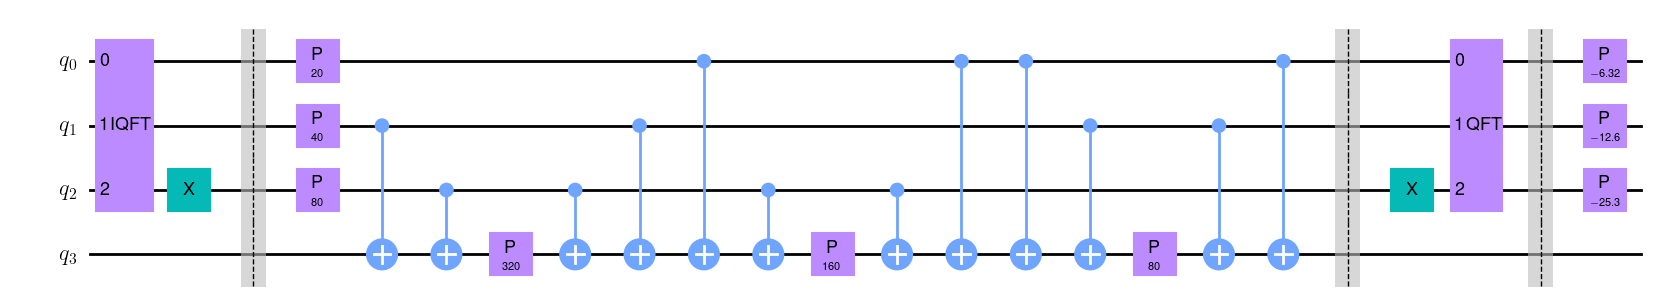

In [16]:

num_qubits = 3

qc = QuantumCircuit(num_qubits + 1)

qc = make_hamiltonian(qc,phi0,dt,potential_type = 'linear')

qc.draw('mpl')

Great! all is working as we want. Now, we can use the following code to simulate to some timestep:

In [17]:
def simulate_timestep(qc,phi0,dt,num_time_steps,potential_type = 'linear'):

    for _ in range(num_time_steps):
        qc = make_hamiltonian(qc,phi0,dt,potential_type)

    return qc

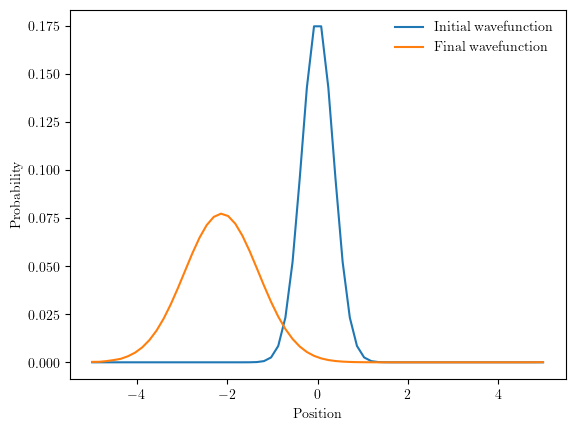

In [24]:
# Now, let us simulate


num_qubits = 6

qc = QuantumCircuit(num_qubits + 1)

phi0 = 0.001

dt = 0.1

x = make_discretized_positions(-5, 5, 2**(num_qubits))

psi = return_gaussian_wavefunction(x, mu, sigma, p0)

# normalize

psi /= np.linalg.norm(psi)

qc.initialize(psi, range(num_qubits ))

qc = simulate_timestep(qc,phi0,dt,20,'linear')

backend = Aer.get_backend('statevector_simulator')

result = execute(qc, backend).result()

psi_qiskit = result.get_statevector()

# Plot the wavefunction

plt.plot(x, np.abs(psi)**2, label = r'$\mathrm{Initial\ wavefunction}$')

plt.plot(x, np.abs(psi_qiskit)[:len(x)]**2, label = r'$\mathrm{Final\ wavefunction}$')

plt.xlabel(r'$\mathrm{Position}$')
plt.ylabel(r'$\mathrm{Probability}$')

plt.legend(frameon = False)

We can make a class to encompass all of this

In [26]:
class Schrodinger():
    def __init__(self) -> None:
        self.dx = None
        self.x_min = -5
        self.x_max = 5
        self.slope = None
        self.coefficient = None
        self.mu = -2.5
        self.sigma = 0.5
        self.p0 = 0.0
        self.num_time_steps = None
        self.dt = 0.01

    def _set_coefficient(self, coefficient):
        self.coefficient = coefficient

    def _set_slope(self, slope):
        self.slope = slope

    def _set_x_min(self, x_min):
        self.x_min = x_min

    def _set_x_max(self, x_max):
        self.x_max = x_max

    def _set_mu(self, mu):
        self.mu = mu

    def _set_sigma(self, sigma):
        self.sigma = sigma

    def _set_p0(self, p0):
        self.p0 = p0

    def _set_num_time_steps(self, num_time_steps):
        self.num_time_steps = num_time_steps

    def _set_dt(self, dt):
        self.dt = dt

    def return_gaussian_wavefunction(self, x):
        """
        Make a gaussian wavefunction
        """
        mu = self.mu
        sigma = self.sigma
        p0 = self.p0

        wave = (1/(np.sqrt(2*np.pi*sigma**2)))*\
            np.exp(-((x-mu)**2)/(2*sigma**2) + 1.0j* p0 * (x - mu)) 
        return wave


    def get_discretized_x(self, num_qubits : int):
        """
        This function returns the discretized x values for the simulation.

        Args:
        - num_qubits: The number of qubits in the circuit.

        Returns:
        - x: The discretized x values.
        """

        x_min = self.x_min
        x_max = self.x_max
        
        x = np.linspace(x_min, x_max, 2**num_qubits)

        self.dx = np.abs(x[1] - x[0])

        return x
    
    def make_linear_phase(self,qc,phi0,dt):
        """
        Method to make the linear phase change.

        params:
        ----------
        qc: QuantumCircuit
            The quantum circuit to simulate.
        phi0: float
            The value of the timestep.
        dt: float
            The value of the time step.

        Returns:
        qc: QuantumCircuit
        """
        
        num_qubits = qc.num_qubits - 1
        for i in range(num_qubits):
            
            phi = -1 / 2**(num_qubits - 3) * phi0 / dt * 2**(num_qubits - i)
            qc.p(phi, num_qubits - i - 1)

        return qc


    def make_quadratic_phase(self,qc, phi0, dt):
        """
        Method to make the quadratic phase. Taken from 
        UMinho thesis and applied the correct terms.

        the quadratic phase is given by:

        k^2 = 1/2^{n - 3} * \phi_0 / \delta t * 2^{n - i}\\
        (1 + \sum_{i = 1}2^{n - i}Z_i + \sum_{i,j = 1}2^{2n - i - j}Z_iZ_k)
        

        params:
        ----------
        qc: QuantumCircuit
            The quantum circuit to simulate.
        phi0: float
            The value of the timestep.
        dt: float
            The value of the time step.

        Returns:
        qc: QuantumCircuit

        """

        num_qubits = qc.num_qubits - 1  # Assuming the last qubit is an auxiliary qubit
        auxiliary_qubit = num_qubits  # Index of the auxiliary qubit

        for i in range(num_qubits):
            phi = 1 / 2**(num_qubits - 3) * phi0 / dt * 2**(num_qubits - i)
            qc.p(phi, num_qubits - i - 1)


        # Your existing logic here, corrected for proper indexing
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                phi = 1 / 2**(num_qubits - 3) * phi0 / dt * 2**(2 * num_qubits - i - j)

                # Use auxiliary_qubit as the target for CX gates
                qc.cx(num_qubits - 1 - j, auxiliary_qubit)
                qc.cx(num_qubits - 1 - i, auxiliary_qubit)
                qc.p(phi, auxiliary_qubit)
                qc.cx(num_qubits - 1 - i, auxiliary_qubit)
                qc.cx(num_qubits - 1 - j, auxiliary_qubit)

        return qc


    def make_hamiltonian(self,qc,phi0,dt,potential_type = 'linear'):

        num_qubits = qc.num_qubits - 1

        qc.append(QFT(num_qubits, inverse = True), range(num_qubits))
        qc.x(num_qubits-1)

        qc.barrier()
        qc = self.make_quadratic_phase(qc,phi0,dt)

        qc.barrier()

        qc.x(num_qubits-1)
        qc.append(QFT(num_qubits), range(num_qubits))

        qc.barrier()

        if potential_type == 'linear':
            qc = self.make_linear_phase(qc,phi0*self.slope,dt)

        if potential_type == 'quadratic':
            qc = self.make_quadratic_phase(qc,phi0*self.coefficient,dt)

        if potential_type == 'free':
            pass


        return qc
    
    def simulate(self,qc,phi0,dt,num_time_steps,potential_type = 'linear'):
        """
        Method to simulate the quantum system to time t as
        H^{l\delta t} where l\delta t = t.


        params:
        ----------
        num_qubits: int
            The number of qubits in the circuit.

        phi0: float
            The value of the timestep.

        num_time_steps: int
            The number of time steps to simulate.

        Returns:
        ----------
        psi_qiskit: np.ndarray
            The wavefunction at time t.
        """    
        qc = QuantumCircuit(num_qubits + 1)

        x = self.get_discretized_x(num_qubits)

        psi = self.return_gaussian_wavefunction(x)

        # normalize

        psi /= np.linalg.norm(psi)

        qc.initialize(psi, range(num_qubits))

            # Simulate
                        
        for _ in range(num_time_steps):
            qc = self.make_hamiltonian(qc,phi0,dt,potential_type)
    
        return qc
    
    def get_statevector(self,qc):
        """
        
        Method to get the statevector of the quantum circuit.

        params:
        ----------
        qc: QuantumCircuit
            The quantum circuit to simulate.

        Returns:
        ----------
        psi_qiskit: np.ndarray

        """
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc, backend).result()
        psi_qiskit = result.get_statevector()
        return psi_qiskit
    
    def make_statevector_heatmap(self,num_qubits,phi0,num_time_steps,potential_type = 'linear'):
        """
        Method to make a heatmap of the statevector at each time step.

        params:
        ----------
        num_time_steps: int
            The number of time steps to simulate.

        Returns:
        ----------
        statevector_results: np.ndarray
        """

        statevector_results = []

        
        for i in range(num_time_steps):
            qc = QuantumCircuit(num_qubits + 1)
            x = self.get_discretized_x(num_qubits)

            psi = self.return_gaussian_wavefunction(x)

            # normalize

            psi /= np.linalg.norm(psi)

            qc.initialize(psi, range(num_qubits))

            psi = self.simulate(num_qubits, phi0, self.dt, i, potential_type)
            statevector_results.append(self.get_statevector(psi)) 

        return statevector_results

    def plot_simulation_at_timestep(self, 
                                num_qubits, 
                                phi0, 
                                num_time_steps, 
                                potential_type = 'linear'):
        
        """

        Method to plot the wavefunction at a given time step.

        params:
        ----------
        num_qubits: int
            The number of qubits in the circuit.
        phi0: float
            The value of the timestep.
        num_time_steps: int
            The number of time steps to simulate.
        potential_type: str 
            The type of potential to simulate.

        Returns:
        ----------
        None
        """

        psi = self.simulate(num_qubits, phi0, num_time_steps, potential_type)

        x = self.get_discretized_x(num_qubits)

        plt.plot(x, np.abs(psi)[:len(x)]**2, label = 'Final wavefunction')


    def draw_circuit_at_timestep(self, num_qubits, 
                                 phi0, 
                                 num_time_steps, 
                                 potential_type = 'linear',reps = 1):

        qc = QuantumCircuit(num_qubits + 1)

        x = self.get_discretized_x(num_qubits)
        dt = self.dt

        psi = self.return_gaussian_wavefunction(x)

        # normalize

        psi /= np.linalg.norm(psi)

        # Initialize the quantum state

        qc.initialize(psi, range(num_qubits))

        for _ in range(num_time_steps):
            qc = self.return_hamiltonian(qc, phi0, dt, potential_type)

        return qc.decompose(reps = reps).draw('mpl')


/var/folders/tm/f3mj_8392ynf5d34j_d9js4m0000gn/T/ipykernel_29200/1150645903.py:9: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  shape = len(results[0])//2


Text(0.5, 0, '$\\mathrm{Time}$')

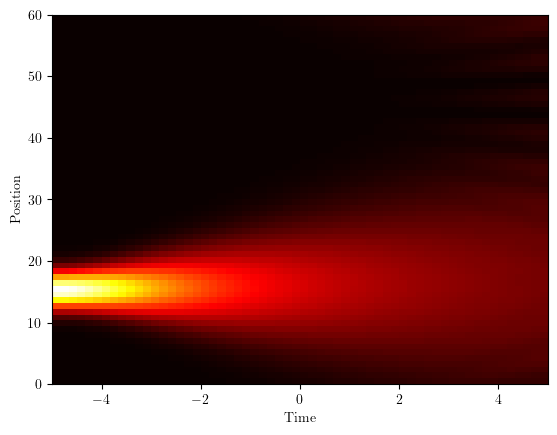

In [34]:
schro = Schrodinger()

schro._set_slope(-4.8)

phi0 = 0.0001

results = schro.make_statevector_heatmap(10, phi0, 60, potential_type = 'free')

shape = len(results[0])//2

extent = [-5, 5, 0, 60]

plt.imshow(np.abs(results)[:,:shape].T**2,
            extent = extent,  
            origin='lower',
            aspect = 'auto', 
            cmap = 'hot')
plt.ylabel(r'$\mathrm{Position}$')
plt.xlabel(r'$\mathrm{Time}$')
plt.title(r'$\mathrm{Free\ Particle}$')

/var/folders/tm/f3mj_8392ynf5d34j_d9js4m0000gn/T/ipykernel_29200/3109462148.py:10: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  shape = len(results[0])//2


Text(0.5, 0, '$\\mathrm{Time}$')

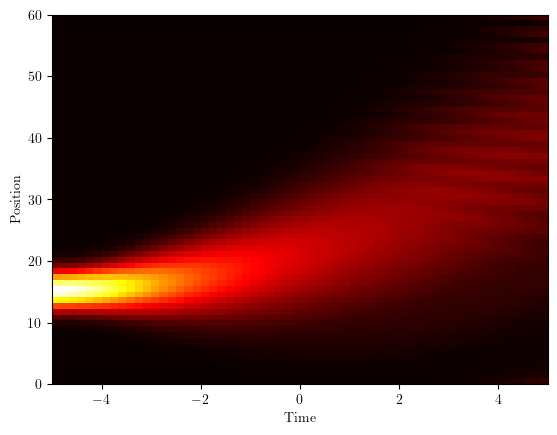

In [35]:
schro = Schrodinger()

schro._set_slope(-4.8)
schro._set_coefficient(0.5)

phi0 = 0.0001

results = schro.make_statevector_heatmap(10, phi0, 60, potential_type = 'linear')

shape = len(results[0])//2

extent = [-5, 5, 0, 60]

plt.imshow(np.abs(results)[:,:shape].T**2,
            extent=extent,
            origin='lower',
            aspect = 'auto', 
            cmap = 'hot')
plt.ylabel(r'$\mathrm{Position}$')
plt.xlabel(r'$\mathrm{Time}$')
plt.title(r'$\mathrm{linear\ potential}$')

/var/folders/tm/f3mj_8392ynf5d34j_d9js4m0000gn/T/ipykernel_29200/1827126498.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  shape = len(results[0])//2


Text(0.5, 0, '$\\mathrm{Time}$')

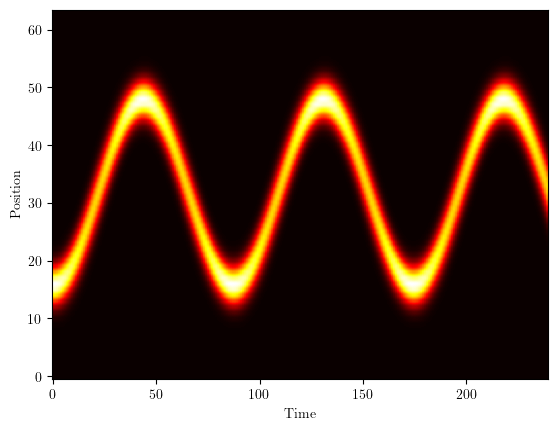

In [33]:
schro = Schrodinger()

schro._set_slope(-4.8)
schro._set_coefficient(0.5)

phi0 = 0.0001

extent = [-5, 5, 0, 240]

results = schro.make_statevector_heatmap(10, phi0, 240, potential_type = 'quadratic')

shape = len(results[0])//2

plt.imshow(np.abs(results)[:,:shape].T**2,
            extent = extent,
            origin='lower',
            aspect = 'auto', 
            cmap = 'hot')


plt.ylabel(r'$\mathrm{Position}$')
plt.xlabel(r'$\mathrm{Time}$')
plt.title(r'$\mathrm{Harmonic\ Potential}$')